# Project: Random Forests

This project will focus on creating and improving a model for the Tanzania Water Pump dataset. The goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.

# I. Wrangle Data

In [ ]:
# Imports
%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

from category_encoders import OrdinalEncoder
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Downloading dataset

# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

# work directory
%cd /content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge


In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Convert columns to datetime
    df[['date_recorded','construction_year']] = df[['date_recorded','construction_year']].apply(pd.to_datetime)

    # Feature engineer column 'pump_age' by using 'construction_year' and 'date_recorded'
    df['pump-age'] = (df['date_recorded'] - df['construction_year'])/np.timedelta64(1, 'Y')

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)
    
    # Drop columns with high proportion of zeros
    df.drop(columns= 'num_private', inplace=True)

    # Drop 'construction_year' and 'date_recorded' columns
    df.drop(columns=['construction_year', 'date_recorded'], inplace= True)               

    return df

In [ ]:
df = wrangle('/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge/train_features.csv', '/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge/train_labels.csv')
X_test = wrangle('/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge/test_features.csv')

In [ ]:
df.sample(5)

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump-age
id,,,,,,,,,,,,,,,,,,,,,
43979.0,NaN,NaN,33.584817,-3.195961,Lake Victoria,Shinyanga,17,2.0,NaN,True,...,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,NaN
39977.0,1000.0,728.0,36.058550,-10.971401,Ruvuma / Southern Coast,Ruvuma,10,5.0,300.0,True,...,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,43.154890
19446.0,NaN,1519.0,36.890395,-3.195145,Internal,Arusha,2,7.0,350.0,True,...,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,43.587480
35370.0,50.0,-8.0,38.659109,-6.804926,Wami / Ruvu,Pwani,6,2.0,50.0,True,...,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional,41.158956
50495.0,NaN,1368.0,37.092574,-3.181783,Pangani,Kilimanjaro,3,7.0,1.0,True,...,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,43.201435


In [ ]:
# Features with Nan values
df.isnull().sum()

amount_tsh               33330
gps_height               16274
longitude                 1433
latitude                  1433
basin                        0
region                       0
region_code                  0
district_code               19
population               17047
public_meeting            2688
scheme_management         3102
permit                    2439
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
status_group                 0
pump-age                 16502
dtype: int64

# II. Split Data

Split DataFrame `df` into a feature matrix `X` and the target vector `y`. We want to predict `'status_group'`.

In [ ]:
target= 'status_group'
X = df.drop(columns=target)
y = df[target]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# III. Establish Baseline

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


**Insights:** If we predicted that all of the incoming new observations are functional, we would probably be accurate by around 54%.

# IV. Build Model


In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42)
    )

# Fit the model
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -

# V. Check Metrics

In [ ]:
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9954228593976062
Validation Accuracy Score: 0.7901936026936027


**Insights:**

- The training accuracy is 99.54%.
- The validation accuracy is 79% (lesser than the training).
- We could say the model is overfit.
- The model generalization isn't great but is acceptable.

# VI. Tune Model

Tune `n_estimators` and `max_depth` hyperparameters for the `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [ ]:
train_acc = []
val_acc = []
max_depth_list = np.arange(1, 100, 10)

for depth in max_depth_list:
  model_rf_tune = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(random_state=42, max_depth=depth))

  model_rf_tune.fit(X_train, y_train)

  train_acc.append(model_rf_tune.score(X_train, y_train))
  val_acc.append(model_rf_tune.score(X_val, y_val))


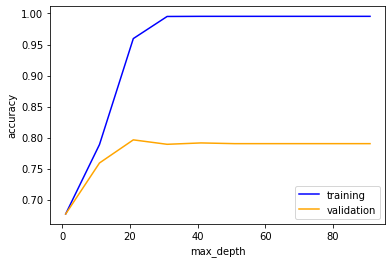

In [ ]:
plt.plot(max_depth_list, train_acc, color='blue', label= 'training')
plt.plot(max_depth_list, val_acc, color='orange', label= 'validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show();

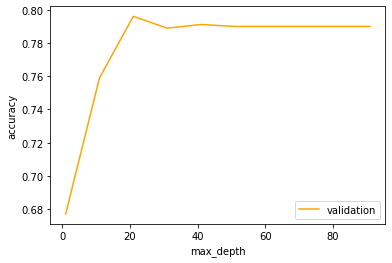

In [ ]:
plt.plot(max_depth_list, val_acc, color='orange', label= 'validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show();

In [ ]:
# Retraining Random Forest after tuning max_depth

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    RandomForestClassifier(max_depth = 18, random_state=42)
)

model_rf.fit(X_train, y_train);

In [ ]:
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val, y_val))

FOREST: Training Accuracy: 0.9162698934631067
FOREST: Validation Accuracy: 0.7961910774410774


**Insight:** 
- Our model is still overfit but it's able to generalize slightly better. The validation accuracy has improved from 79.01% to 79.62%. 
- It seems like the overfitting was reduced quite a bit. There's a decrease from 99.54% to close to 91.62%. 

In [ ]:
train_acc = []
val_acc = []
n_estimators_list = np.arange(1, 100, 20)

for estimator in n_estimators_list:
  model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    RandomForestClassifier(max_depth=18, n_estimators=estimator, random_state=42) 
    )
  
  model_rf.fit(X_train, y_train);

  train_acc.append(model_rf.score(X_train, y_train))
  val_acc.append(model_rf.score(X_val, y_val))


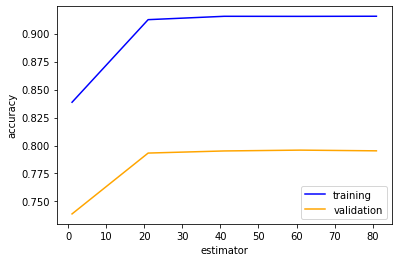

In [ ]:
plt.plot(n_estimators_list, train_acc, color='blue', label= 'training')
plt.plot(n_estimators_list, val_acc, color='orange', label= 'validation')
plt.xlabel('estimator')
plt.ylabel('accuracy')
plt.legend()
plt.show();

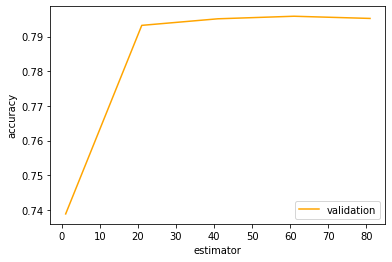

In [ ]:
plt.plot(n_estimators_list, val_acc, color='orange', label= 'validation')
plt.xlabel('estimator')
plt.ylabel('accuracy')
plt.legend()
plt.show();

In [ ]:
# Retraining Random Forest after tuning n_estimators

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    RandomForestClassifier(n_estimators= 17, max_depth = 18, random_state=42)
)

model_rf.fit(X_train, y_train);

In [ ]:
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val, y_val))

FOREST: Training Accuracy: 0.9127186636853873
FOREST: Validation Accuracy: 0.7948232323232324


**Insights:** Tuning the n_estimators did not improve the model's performance. Since this is not helpful, we decided to use the default value of estimators.

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    RandomForestClassifier(max_depth = 18, random_state=42)
)

model_rf.fit(X_train, y_train);

In [ ]:
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val, y_val))

FOREST: Training Accuracy: 0.9162698934631067
FOREST: Validation Accuracy: 0.7961910774410774


# VII. Communicate Results

Generate a list of predictions for `X_test`. The list is named `y_pred`.

In [ ]:
y_pred = model_rf.predict(X_test)

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

In [ ]:
submission = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)

In [ ]:
submission.columns = ['status_group']
submission

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,functional
47083,functional
...,...
26092,functional
919,non functional
47444,non functional


In [ ]:
# Generate CSV file
submission.to_csv('second_submission.csv')

# Download CSV file
from google.colab import files
files.download('second_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>